# Color Analysis

In [ ]:
from analyze import analyze_color_histogram
from scg_detection_tools.models import YOLO_NAS, YOLOv8
from scg_detection_tools.detect import Detector
from scg_detection_tools.utils.file_handling import read_yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import cv2

cfg = read_yaml("analyze_config.yaml")
#model = YOLOv8(yolov8_ckpt_path=cfg["yolov8_model_path"])
model = YOLO_NAS(model_arch=cfg["yolonas_arch"], 
                 checkpoint_path=cfg["yolonas_model_path"], 
                 classes=cfg["data_classes"])
det_params = cfg["detect_parameters"]
det_params["embed_slice_callback"] = None
det = Detector(detection_model=model, detection_params=det_params)


In [ ]:
from scg_detection_tools.utils.file_handling import get_all_files_from_paths

IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/images"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/labels"

#IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/hemacias/images"

imgs = get_all_files_from_paths(IMG_DIR)

img_hists = analyze_color_histogram(model=model, 
                                    detector=det, 
                                    imgs=imgs, 
                                    raw=False, 
                                    on_detection_boxes=False,
                                    seg_annotations=LBL_DIR, 
                                    cspaces=["RGB", "HSV", "GRAY"], 
                                    show=True, save_plots=False)


In [ ]:
# Plot single channel images

import os

save = False
for img in imgs:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    
    rgb = cv2.imread(img)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb.copy(), cv2.COLOR_RGB2HSV)
    LABELS = ["RGB", "HSV"]
    for ci, cp in enumerate([rgb, hsv]):
        for i in range(3):
            ch = cp.copy()
            for j in range(3):
                if i != j:
                    ch[:,:,j] = 0
            axs[ci][i].axis("off")
            axs[ci][i].imshow(ch)
            axs[ci][i].set_title(LABELS[ci][i])
    if save:
        fig.savefig(f"exp_analysis/singlechannel_{os.path.basename(img)}")
    plt.show()

In [ ]:
cspaceAnalysis = {"RGB": [], "HSV": [], "GRAY": [], "ALL": []}
nclass = {0: "light", 1: "medium", 2: "dark", 3: "dead"}
intensities = np.arange(256)

for img in img_hists:
    img_hist = img_hists[img]
    for cspace in ["RGB", "HSV", "GRAY"]:
        for mask_hist in img_hist[cspace]["masks"]:
            hist = mask_hist["hist"]
            mask_class = nclass[mask_hist["class"]]

            ch_stats = []
            for ch_hist in hist:
                ch_mean = np.sum(intensities * ch_hist) / np.sum(ch_hist)
                ch_std = np.sqrt(np.sum((intensities - ch_mean) ** 2 * ch_hist) / np.sum(ch_hist))
                ch_stats.append([ch_mean, ch_std])
            
            ch_stats = np.array(ch_stats).T.ravel().tolist()
            ch_stats.append(mask_class)
            cspaceAnalysis[cspace].append(ch_stats)


num_masks = len(cspaceAnalysis["RGB"])
all_mean = []
all_std = []
all_class = [data[-1] for data in cspaceAnalysis["RGB"]]

for maskidx in range(num_masks):
    all_mean.append([])
    all_std.append([])
    for cspace in ["RGB", "HSV", "GRAY"]:
        data = cspaceAnalysis[cspace][maskidx]
        if cspace == "GRAY":
            ch_mean = data[0]
            ch_std = data[1]
            all_mean[-1].append(ch_mean)
            all_std[-1].append(ch_std)
        else:
            ch_mean = data[:3]
            ch_std = data[3:-1]
            all_mean[-1].extend(ch_mean)
            all_std[-1].extend(ch_std)
for i in range(num_masks):
    cspaceAnalysis["ALL"].append([])
    
    cspaceAnalysis["ALL"][i].extend(all_mean[i])
    cspaceAnalysis["ALL"][i].extend(all_std[i])
    cspaceAnalysis["ALL"][i].append(all_class[i])

rgbdf = pd.DataFrame(cspaceAnalysis["RGB"], columns=[
    "R Mean", "G Mean", "B Mean", "R std", "G std", "B std", "Class"
])
hsvdf = pd.DataFrame(cspaceAnalysis["HSV"], columns=[
    "H Mean", "S Mean", "V Mean", "H std", "S std", "V std", "Class"
])
graydf = pd.DataFrame(cspaceAnalysis["GRAY"], columns=[
    "Gray mean", "Gray std", "Class"
])

alldf = pd.DataFrame(cspaceAnalysis["ALL"], columns=[
    "R Mean", "G Mean", "B Mean", "H Mean", "S Mean", "V Mean", "Gray mean", "R std", "G std", "B std", "H std", "S std", "V std", "Gray std", "Class"
])

class_c_map = {
    "light": "b", 
    "medium": "g", 
    "dark": "r", 
    "dead": "k"
}

class_color = lambda df: df["Class"].map(class_c_map)

scatter_matrix(rgbdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(rgbdf))
scatter_matrix(hsvdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(hsvdf))
scatter_matrix(graydf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(graydf))
scatter_matrix(alldf.iloc[:,:-1], figsize=(20,20), diagonal="kde", c=class_color(alldf))

print(rgbdf.corr(numeric_only=True))
print(hsvdf.corr(numeric_only=True))
print(graydf.corr(numeric_only=True))

# Clustering and Classification

In [ ]:
"""
KMeans:

Use k-means to find clusters based on leaf masks extracted with yolo and sam2
- (for now) use the features from above (RGB, HSV, Gray means and std), pass them to PSA
- to get it to 2 and 3 dimensions (compare them) then use them to train KMeans
- and also plot inertia x n_clusters to check for optimal values
"""

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# alldf is a dataset of 14 features (RGB,HSV,Gray)(Mean,STD) not including class
# it will only be used to color markers in plot
#print(alldf.head())
#print(alldf.iloc[:,:-1].values)
X = alldf.iloc[:,:-1].values

# Use PCA to reduce to 2d
reduced = PCA(n_components=2).fit_transform(X)

In [ ]:
# Analyze inertia to choose best numbmer for clusters
inertia = []
MAX_CLUSTERS = 15
for n in range(1, MAX_CLUSTERS):
    kmeans = KMeans(n_clusters=n, init="k-means++", n_init=10, max_iter=300,
                    tol=0.0001, random_state=0, algorithm="lloyd")
    kmeans.fit(reduced)
    inertia.append(kmeans.inertia_)


fig, ax = plt.subplots()
ax.plot(np.arange(1, MAX_CLUSTERS), inertia, marker='o')
ax.set(xlabel="# Clusters", ylabel="Inertia")
plt.show()

In [7]:
# Choosing N clusters because of above
N_CLUSTERS = 4
kmeans = KMeans(n_clusters=N_CLUSTERS, init="k-means++", max_iter=300,
                tol=0.0001, random_state=0, algorithm="lloyd")
kmeans.fit(reduced)

KMeans(n_clusters=4, random_state=0)

In [8]:
# Visualize clusters
h = 0.02

x_min, x_max = reduced[:,0].min() - 1, reduced[:,0].max() + 1
y_min, y_max = reduced[:,1].min() - 1, reduced[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

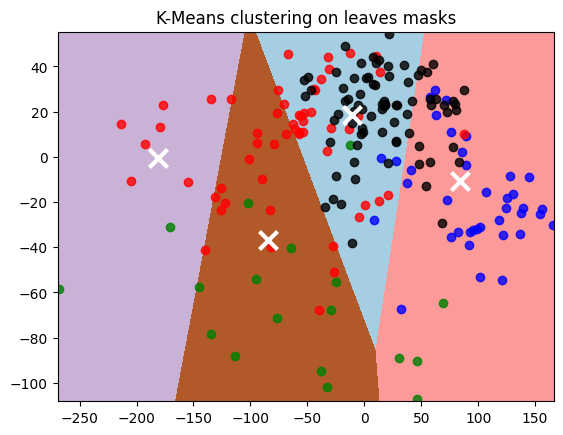

In [9]:
fig, ax = plt.subplots()
ax.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired, aspect="auto", origin="lower")

for c in class_c_map:
    c_data = reduced[alldf["Class"] == c,:]
    ax.scatter(c_data[:,0], c_data[:,1], color=class_c_map[c], alpha=0.8)

#ax.plot(reduced[:,0], reduced[:,1], )
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:,0], centroids[:,1], marker="x", s=169, color="w", zorder=10, linewidth=3)
ax.set(title="K-Means clustering on leaves masks",
       xlim=(x_min, x_max),
       ylim=(y_min, y_max))

plt.show()

In [ ]:
"""
K Nearest Neighbours:

"""

# Pixel density

In [ ]:
from analyze import analyze_pixel_density
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from pathlib import Path

IMG_DIR = "/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/first_analysis_detections/out_cache/"

imgs = get_all_files_from_paths(IMG_DIR)

def sort_stem(item):
    s = Path(item).stem
    try:
        val = int(s)
        return val
    except:
        return s

imgs = sorted(imgs, key=sort_stem)
print(imgs)

densities = analyze_pixel_density(model=model, 
                                  detector=det, 
                                  imgs=imgs, 
                                  sam2_ckpt_path=cfg["sam2_ckpt_path"],
                                  sam2_cfg=cfg["sam2_cfg"],
                                  boxes=True,
                                  segments=False,
                                  slice_detection=True,
                                  on_slice=False,
                                  seg_annotations=None,
                                  cached_detections=None,
                                  show=True,
                                  save=True)
print(densities)